In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
from astropy.table import Table
from copy import deepcopy
from glob import glob
from matplotlib import colors
from matplotlib.ticker import MaxNLocator
from pprint import pprint
import yaml
from tqdm import tqdm

# enable use of local modules
repo_dir = '/grad/bwedig/mejiro'
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.galaxy_galaxy import GalaxyGalaxy, SampleGG, SampleBELLS, SampleSL2S
from mejiro.exposure import Exposure
from mejiro.utils import util

# read configuration file
with open(f'{repo_dir}/pipeline/yaml_config_scripts/config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

In [2]:
dev = config['dev']
total = config['survey']['total_population']

if dev:
    pipeline_dir = os.path.join(config["data_dir"], config["pipeline_dir"] + '_dev')
else:
    pipeline_dir = os.path.join(config["data_dir"], config["pipeline_dir"])

print(f'pipeline_dir: {pipeline_dir}')

pipeline_dir: /data/bwedig/mejiro/pipeline_dev


In [3]:
# combine CSVs from each run into one CSV
data_dir = os.path.join(pipeline_dir, '01')

rebuild = True

detectable_csv = os.path.join(data_dir, 'detectable_pop.csv')
if rebuild:
    util.delete_if_exists(detectable_csv)
    detectable_df = util.combine_all_csvs(data_dir, 'detectable', detectable_csv)
else:
    detectable_df = pd.read_csv(detectable_csv)

if total:
    total_csv = os.path.join(data_dir, 'total_pop.csv')
    if rebuild:
        util.delete_if_exists(total_csv)
        total_df = util.combine_all_csvs(data_dir, 'total', total_csv)
    else:
        total_df = pd.read_csv(total_csv)

Wrote combined CSV to /data/bwedig/mejiro/pipeline_dev/01/detectable_pop.csv
Wrote combined CSV to /data/bwedig/mejiro/pipeline_dev/01/total_pop.csv


In [4]:
# total_df.columns
# hist = total_df.hist(grid=False, figsize=(20, 20))

# detectable_df.columns
# hist = detectable_df.hist(grid=False, figsize=(20, 20))

# slacs_df.columns
# hist = slacs_df.hist(grid=False, figsize=(20, 20))
# plt.savefig(os.path.join(figure_dir, 'slacs_hist.png'))

In [5]:
table_dir = os.path.join(repo_dir, 'paper', 'tables')

slacs4_df = pd.read_csv(os.path.join(table_dir, 'Bolton2008_Table4.csv'))
slacs5_df = pd.read_csv(os.path.join(table_dir, 'Bolton2008_Table5.csv'))
bells1_df = pd.read_csv(os.path.join(table_dir, 'Shu2016a_table1.csv'))
bells2_df = pd.read_csv(os.path.join(table_dir, 'Shu2016a_table2.csv'))
sonnenfeld2_df = pd.read_csv(os.path.join(table_dir, 'Sonnenfeld2013b_table2.csv'))

from astropy.io import fits

with fits.open(os.path.join(table_dir, 'Sonnenfeld2013a_table6.fit')) as hdul:
    sonnenfeld6_data = Table(hdul[1].data)
    sonnenfeld6_df = sonnenfeld6_data.to_pandas()

In [6]:
source_cut_band = config['survey']['source_cut_band']
deflector_cut_band = config['survey']['deflector_cut_band']
snr_threshold = config['snr']['snr_threshold']

select histograms to show

In [7]:
# detectable lenses
velocity_dispersions = detectable_df.loc[:, 'velodisp']
masses = detectable_df.loc[:, 'massstel'] * 1e12
source_redshifts = detectable_df.loc[:, 'redssour']
lens_redshifts = detectable_df.loc[:, 'redslens']
einstein_radii = detectable_df.loc[:, 'angleins']
num_images = detectable_df.loc[:, 'numbimag']
source_magnitudes = detectable_df.loc[:, f'magtsour{source_cut_band}']
lens_magnitudes = detectable_df.loc[:, f'magtlens{deflector_cut_band}']

# total lenses
if total:
    total_velocity_dispersions = total_df.loc[:, 'velodisp']
    total_masses = total_df.loc[:, 'massstel'] * 1e12
    total_source_redshifts = total_df.loc[:, 'redssour']
    total_lens_redshifts = total_df.loc[:, 'redslens']
    total_einstein_radii = total_df.loc[:, 'angleins']
    total_num_images = total_df.loc[:, 'numbimag']
    total_source_magnitudes = total_df.loc[:, f'magtsour{source_cut_band}']
    total_lens_magnitudes = total_df.loc[:, f'magtlens{deflector_cut_band}']

# SLACS
slacs_velocity_dispersions = slacs4_df.loc[:, 'sigma']
slacs_source_redshifts = slacs4_df.loc[:, 'zBG']
slacs_lens_redshifts = slacs4_df.loc[:, 'zFG']
slacs_einstein_radii = slacs5_df.loc[:, 'bSIE']

# BELLS
bells_velocity_dispersions = bells1_df.loc[:, 'sigma_BOSS']
bells_source_redshifts = bells1_df.loc[:, 'z_S']
bells_lens_redshifts = bells1_df.loc[:, 'z_L']
bells_einstein_radii = bells2_df.loc[:, 'b_SIE']

# SL2S
sl2s_velocity_dispersions = sonnenfeld2_df.loc[:, 'sigma']  # .dropna()
sl2s_source_redshifts = sonnenfeld2_df.loc[:, 'z_s']  # .dropna()
sl2s_lens_redshifts = sonnenfeld2_df.loc[:, 'z_d']  # .dropna()
sl2s_einstein_radii = sonnenfeld6_df.loc[:, 'Reff']

# total HST
hst_velocity_dispersions = slacs_velocity_dispersions.to_list() + bells_velocity_dispersions.to_list() + sl2s_velocity_dispersions.to_list()
hst_source_redshifts = slacs_source_redshifts.to_list() + bells_source_redshifts.to_list() + sl2s_source_redshifts.to_list()
hst_lens_redshifts = slacs_lens_redshifts.to_list() + bells_lens_redshifts.to_list() + sl2s_lens_redshifts.to_list()
hst_einstein_radii = slacs_einstein_radii.to_list() + bells_einstein_radii.to_list() + sl2s_einstein_radii.to_list()

# remove unreliable velocity dispersion 850 from BELLS GAllERY (see note in Table 1 of Shu2016b https://ui.adsabs.harvard.edu/abs/2016ApJ...833..264S/abstract)
bells_velocity_dispersions = bells_velocity_dispersions[bells_velocity_dispersions != 850]

normalize number of images

In [8]:
num_2 = len(num_images[num_images == 2])
num_3 = len(num_images[num_images == 3])
num_4 = len(num_images[num_images == 4])
total = len(num_images)

normalized_num_2 = num_2 / total
normalized_num_3 = num_3 / total
normalized_num_4 = num_4 / total

get SNRs

In [9]:
snr_files = glob(f'{data_dir}/snr_list_*.npy')
snr_list = list(itertools.chain.from_iterable([np.load(f) for f in snr_files]))

In [10]:
# largest Einstein radius
max_einstein_radius = max(einstein_radii)
print(f'Maximum Einstein radius: {max_einstein_radius}')

Maximum Einstein radius: 2.970254790480209


In [11]:
count_lens_redshifts_ge_1 = (lens_redshifts >= 1).sum()
print(f'Number of total lens redshifts >= 1: {count_lens_redshifts_ge_1}')
print(f'In total HLWAS, {round(count_lens_redshifts_ge_1 * (1700 / 270))}')

Number of total lens redshifts >= 1: 621
In total HLWAS, 3910


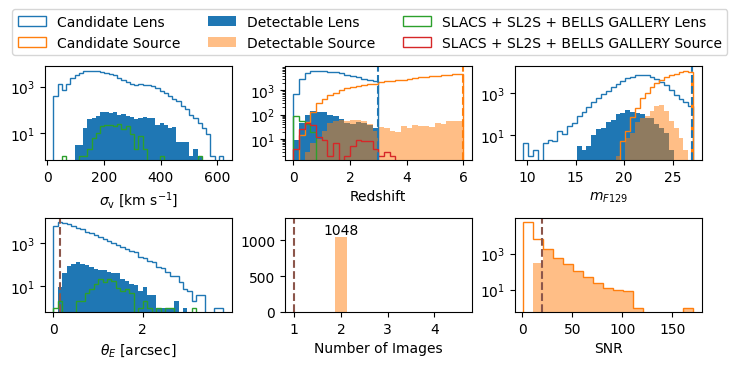

In [12]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(7, 3), constrained_layout=True)

# colors
color_lens = 'C0'
color_source = 'C1'
color_slacs_lens = 'C2'
color_slacs_source = 'C3'
color_else = 'C5'

alpha_detectable_lens = 1.
alpha_detectable_source = 0.5
alpha_hst_lens = 1
alpha_hst_source = 1

binwidth = 15
bins = np.arange(min(total_velocity_dispersions), max(total_velocity_dispersions) + binwidth, binwidth)
if total: ax[0][0].hist(total_velocity_dispersions, label='Total', histtype='step', color=color_lens, bins=bins)
ax[0][0].hist(velocity_dispersions, label='Detectable', alpha=alpha_detectable_lens, color=color_lens, bins=bins)
ax[0][0].hist(hst_velocity_dispersions, label='SLACS', alpha=alpha_hst_lens, color=color_slacs_lens, bins=bins,
              histtype='step')
ax[0][0].set_xlabel(r'$\sigma_\text{v}$ [km s$^{-1}$]')
ax[0][0].set_yscale('log')

binwidth = 0.2
bins = np.arange(0, max(total_source_redshifts) + binwidth, binwidth)
if total: ax[0][1].hist(total_lens_redshifts, label='Candidate Lens', histtype='step', color=color_lens,
                        bins=bins)  # , align='left'
if total: ax[0][1].hist(total_source_redshifts, label='Candidate Source', histtype='step', color=color_source,
                        bins=bins)  # , align='left'
ax[0][1].hist(lens_redshifts, label='Detectable Lens', alpha=alpha_detectable_lens, color=color_lens, bins=bins)
ax[0][1].hist(source_redshifts, label='Detectable Source', alpha=alpha_detectable_source, color=color_source, bins=bins)
ax[0][1].hist(hst_lens_redshifts, label='SLACS + SL2S + BELLS GALLERY Lens', alpha=alpha_hst_lens,
              color=color_slacs_lens, bins=bins, histtype='step')
ax[0][1].hist(hst_source_redshifts, label='SLACS + SL2S + BELLS GALLERY Source', alpha=alpha_hst_source,
              color=color_slacs_source, bins=bins, histtype='step')
ax[0][1].axvline(config['survey']['source_z_max'], color=color_source, linestyle='--')
ax[0][1].axvline(config['survey']['deflector_z_max'], color=color_lens, linestyle='--')
ax[0][1].set_yscale('log')
ax[0][1].set_xlabel('Redshift')

# x1, x2, y1, y2 = 0, 2.25, 0.5, 1e3
# zoom_axes = ax[0][1].inset_axes(bounds=[0.475,0.3,0.425,0.45], xlim=(x1, x2), ylim=(y1, y2))
# zoom_axes.hist(source_redshifts, label='Detectable Source', alpha=0.75)
# zoom_axes.hist(lens_redshifts, label='Detectable Lens', alpha=0.75)
# zoom_axes.hist(slacs_source_redshifts, label='SLACS Source', alpha=0.5, color='y')
# zoom_axes.hist(slacs_lens_redshifts, label='SLACS Lens', alpha=0.5, color='r')
# zoom_axes.set_yscale('log')
# zoom_axes.tick_params(axis='y', which='both', left=False, labelleft=False)
# zoom_axes.set_xticks([0, 1.5])
# ax[0][1].indicate_inset_zoom(zoom_axes, edgecolor="black")

binwidth = 0.5
bins = np.arange(min(total_lens_magnitudes), max(total_lens_magnitudes) + (binwidth / 2), binwidth)
if total: ax[0][2].hist(total_lens_magnitudes, histtype='step', color=color_lens, bins=bins)
if total: ax[0][2].hist(total_source_magnitudes, histtype='step', color=color_source, bins=bins)
ax[0][2].hist(lens_magnitudes, alpha=alpha_detectable_lens, color=color_lens, bins=bins)
ax[0][2].hist(source_magnitudes, alpha=alpha_detectable_source, color=color_source, bins=bins)
ax[0][2].axvline(config['survey']['source_cut_band_max'], linestyle='-.', color=color_source)
ax[0][2].axvline(config['survey']['deflector_cut_band_max'], linestyle='--', color=color_lens)
ax[0][2].set_yscale('log')
assert source_cut_band == deflector_cut_band, 'Source and deflector cut bands must be the same for the label on this plot to be true'
ax[0][2].set_xlabel(r'$m_{%s}$' % source_cut_band)
# ax[0][2].invert_xaxis()

binwidth = 0.1
bins = np.arange(0, max(total_einstein_radii) + binwidth, binwidth)
if total: ax[1][0].hist(total_einstein_radii, histtype='step', color=color_lens, bins=bins)
ax[1][0].hist(einstein_radii, alpha=alpha_detectable_lens, color=color_lens, bins=bins)
ax[1][0].hist(hst_einstein_radii, alpha=alpha_hst_lens, color=color_slacs_lens, bins=bins, histtype='step')
ax[1][0].axvline(config['survey']['min_image_separation'] / 2, linestyle='--', color=color_else)
ax[1][0].set_xlabel(r'$\theta_E$ [arcsec]')
ax[1][0].set_yscale('log')
# ax[1][0].set_xlim([0,2])

labels, counts = np.unique(num_images, return_counts=True)
bars = ax[1][1].bar(labels, counts, label='Detectable', alpha=alpha_detectable_source, color=color_source, width=0.25)
# counts, edges, bars = ax[1][1].hist(num_images, label='Detectable', alpha=alpha_detectable_source, color=color_source)
# bar_2 = ax[1][1].bar(2, normalized_num_2, label='Detectable', alpha=0.5, color=color_source, width=0.25)
# bar_3 = ax[1][1].bar(3, normalized_num_3, alpha=0.5, color=color_source, width=0.25)
# bar_4 = ax[1][1].bar(4, normalized_num_4, alpha=0.5, color=color_source, width=0.25)
ax[1][1].axvline(1, linestyle='--', color=color_else)
ax[1][1].set_xlabel('Number of Images')
labels = [int(v) if v > 0 else '' for v in counts]
ax[1][1].bar_label(bars, labels=labels, label_type='edge')
# ax[1][1].bar_label(bar_2, labels=[f'{normalized_num_2:.2f}'], label_type='edge')
# ax[1][1].bar_label(bar_3, labels=[f'{normalized_num_3:.2f}'], label_type='edge')
# ax[1][1].bar_label(bar_4, labels=[f'{normalized_num_4:.2f}'], label_type='edge')
ax[1][1].set_xlim([0.8, 4.8])  # make some horizontal space for the bar labels
ax[1][1].set_ylim([0, 1.25 * counts[0]])  # make some vertical space for the bar labels
ax[1][1].xaxis.set_major_locator(MaxNLocator(integer=True))
# ax[1][0].ticklabel_format(axis='y', style='plain', scilimits=(0,0))

bin_width = snr_threshold / 2
snr_list = [snr for snr in snr_list]
bins = np.arange(min(snr_list), max(snr_list) + bin_width, bin_width)
_, bins, _ = ax[1][2].hist(snr_list, bins=bins, label='Total', histtype='step', color=color_source)
detectable_snrs = [i for i in snr_list if i > snr_threshold]
ax[1][2].hist(detectable_snrs, bins=bins[1:], label='Detectable', alpha=alpha_detectable_source, color=color_source)
ax[1][2].axvline(x=snr_threshold, linestyle='--', color=color_else)
ax[1][2].set_xlabel('SNR')
ax[1][2].set_yscale('log')

# create legend using colors and labels from the redshift panel
handles, labels = ax[0][1].get_legend_handles_labels()
f.legend(handles, labels, loc='upper center', ncols=3, bbox_to_anchor=(0.52, 1.2))

# plt.savefig(os.path.join(repo_dir, 'figures', 'skypy_pop_hist.png'))
plt.show()

In [13]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 6), constrained_layout=True)

# colors
color_lens = 'C0'
color_source = 'C1'
color_slacs_lens = 'C2'
color_slacs_source = 'C3'

alpha_detectable_lens = 1.
alpha_detectable_source = 0.5
alpha_hst_lens = 1

# Panel 1: Velocity Dispersions
binwidth = 15
bins = np.arange(min(total_velocity_dispersions), max(total_velocity_dispersions) + binwidth, binwidth)
if total: ax[0][0].hist(total_velocity_dispersions, label=f'Total (mean={np.mean(total_velocity_dispersions):.2f})',
                        histtype='step', color=color_lens, bins=bins, density=True)
ax[0][0].hist(velocity_dispersions, label=f'Detectable (mean={np.mean(velocity_dispersions):.2f})',
              alpha=alpha_detectable_lens, color=color_lens, bins=bins, density=True)
ax[0][0].set_xlabel(r'$\sigma_\textrm{v}$ [km/s]')
ax[0][0].axvline(np.mean(total_velocity_dispersions), color=color_lens, linestyle='--')
ax[0][0].axvline(np.mean(velocity_dispersions), color=color_lens, linestyle='-')
ax[0][0].axvline(np.mean(hst_velocity_dispersions), color=color_slacs_lens, linestyle='--')
ax[0][0].legend()

# Panel 2: Redshifts
binwidth = 0.2
bins = np.arange(0, max(total_source_redshifts) + binwidth, binwidth)
if total: ax[0][1].hist(total_lens_redshifts, label=f'Candidate Lens (mean={np.mean(total_lens_redshifts):.2f})',
                        histtype='step', color=color_lens, bins=bins, density=True)
if total: ax[0][1].hist(total_source_redshifts, label=f'Candidate Source (mean={np.mean(total_source_redshifts):.2f})',
                        histtype='step', color=color_source, bins=bins, density=True)
ax[0][1].hist(lens_redshifts, label=f'Detectable Lens (mean={np.mean(lens_redshifts):.2f})',
              alpha=alpha_detectable_lens, color=color_lens, bins=bins, density=True)
ax[0][1].hist(source_redshifts, label=f'Detectable Source (mean={np.mean(source_redshifts):.2f})',
              alpha=alpha_detectable_source, color=color_source, bins=bins, density=True)
ax[0][1].axvline(survey_params['source_z_max'], color=color_source, linestyle='--')
ax[0][1].axvline(survey_params['deflector_z_max'], color=color_lens, linestyle='--')
ax[0][1].set_xlabel('Redshift')
ax[0][1].axvline(np.mean(total_lens_redshifts), color=color_lens, linestyle='--')
ax[0][1].axvline(np.mean(total_source_redshifts), color=color_source, linestyle='--')
ax[0][1].axvline(np.mean(lens_redshifts), color=color_lens, linestyle='-')
ax[0][1].axvline(np.mean(source_redshifts), color=color_source, linestyle='-')
ax[0][1].axvline(np.mean(hst_lens_redshifts), color=color_slacs_lens, linestyle='--')
ax[0][1].axvline(np.mean(hst_source_redshifts), color=color_slacs_source, linestyle='--')
ax[0][1].legend()

# Panel 3: Magnitudes
binwidth = 0.5
bins = np.arange(min(total_lens_magnitudes), max(total_lens_magnitudes) + (binwidth / 2), binwidth)
if total: ax[0][2].hist(total_lens_magnitudes, label=f'Total Lens (mean={np.mean(total_lens_magnitudes):.2f})',
                        histtype='step', color=color_lens, bins=bins, density=True)
if total: ax[0][2].hist(total_source_magnitudes, label=f'Total Source (mean={np.mean(total_source_magnitudes):.2f})',
                        histtype='step', color=color_source, bins=bins, density=True)
ax[0][2].hist(lens_magnitudes, label=f'Detectable Lens (mean={np.mean(lens_magnitudes):.2f})',
              alpha=alpha_detectable_lens, color=color_lens, bins=bins, density=True)
ax[0][2].hist(source_magnitudes, label=f'Detectable Source (mean={np.mean(source_magnitudes):.2f})',
              alpha=alpha_detectable_source, color=color_source, bins=bins, density=True)
ax[0][2].set_xlabel(r'$m_{%s}$' % source_cut_band)
ax[0][2].axvline(np.mean(total_lens_magnitudes), color=color_lens, linestyle='--')
ax[0][2].axvline(np.mean(total_source_magnitudes), color=color_source, linestyle='--')
ax[0][2].axvline(np.mean(lens_magnitudes), color=color_lens, linestyle='-')
ax[0][2].axvline(np.mean(source_magnitudes), color=color_source, linestyle='-')
ax[0][2].legend()

# Panel 4: Einstein Radii
binwidth = 0.1
bins = np.arange(0, max(total_einstein_radii) + binwidth, binwidth)
if total: ax[1][0].hist(total_einstein_radii, label=f'Total (mean={np.mean(total_einstein_radii):.2f})',
                        histtype='step', color=color_lens, bins=bins, density=True)
ax[1][0].hist(einstein_radii, label=f'Detectable (mean={np.mean(einstein_radii):.2f})', alpha=alpha_detectable_lens,
              color=color_lens, bins=bins, density=True)
ax[1][0].axvline(survey_params['min_image_separation'] / 2, linestyle='--', color=color_source)
ax[1][0].set_xlabel(r'$\theta_E$ [arcsec]')
ax[1][0].axvline(np.mean(total_einstein_radii), color=color_lens, linestyle='--')
ax[1][0].axvline(np.mean(einstein_radii), color=color_lens, linestyle='-')
ax[1][0].axvline(np.mean(hst_einstein_radii), color=color_slacs_lens, linestyle='--')
ax[1][0].legend()

# Panel 5: Number of Images
labels, counts = np.unique(num_images, return_counts=True)
ax[1][1].bar(labels, counts / total, label=f'Detectable (mean={np.mean(num_images):.2f})',
             alpha=alpha_detectable_source, color=color_source, width=0.25)
ax[1][1].set_xlabel('Number of Images')
ax[1][1].set_xlim([0.8, 4.8])
ax[1][1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1][1].axvline(np.mean(num_images), color=color_source, linestyle='-')
ax[1][1].legend()

# Panel 6: SNR
bin_width = snr_threshold / 2
bins = np.arange(min(snr_list), max(snr_list) + bin_width, bin_width)
ax[1][2].hist(snr_list, bins=bins, label=f'Total (mean={np.mean(snr_list):.2f})', histtype='step', color=color_source,
              density=True)
ax[1][2].hist(detectable_snrs, bins=bins[1:], label=f'Detectable (mean={np.mean(detectable_snrs):.2f})',
              alpha=alpha_detectable_source, color=color_source, density=True)
ax[1][2].set_xlabel('SNR')
ax[1][2].axvline(np.mean(snr_list), color=color_source, linestyle='--')
ax[1][2].axvline(np.mean(detectable_snrs), color=color_source, linestyle='-')
ax[1][2].legend()

plt.savefig(os.path.join(figure_dir, 'skypy_pop_hist_frac.png'))
plt.show()

NameError: name 'survey_params' is not defined

Error in callback <function _draw_all_if_interactive at 0x7fcb36fb6dd0> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
\sigma_\textrm{v}
            ^
ParseSyntaxException: Expected \text, found 'rm'  (at char 12), (line:1, col:13)

ValueError: 
\sigma_\textrm{v}
            ^
ParseSyntaxException: Expected \text, found 'rm'  (at char 12), (line:1, col:13)

<Figure size 1400x600 with 6 Axes>

In [ ]:
distributions = {
    'Detectable SNRs': detectable_snrs,
    'Einstein Radii': einstein_radii,
    'Lens Magnitudes': lens_magnitudes,
    'Lens Redshifts': lens_redshifts,
    'Masses': masses,
    'Num Images': num_images,
    'Source Magnitudes': source_magnitudes,
    'Source Redshifts': source_redshifts,
    'Total Einstein Radii': total_einstein_radii,
    'Total Lens Magnitudes': total_lens_magnitudes,
    'Total Lens Redshifts': total_lens_redshifts,
    'Total Masses': total_masses,
    'Total Num Images': total_num_images,
    'Total Source Magnitudes': total_source_magnitudes,
    'Total Source Redshifts': total_source_redshifts,
    'Total Velocity Dispersions': total_velocity_dispersions,
    'Velocity Dispersions': velocity_dispersions
}

for name, data in distributions.items():
    mean = np.mean(data)
    std_dev = np.std(data)
    print(f'{name}: Mean = {mean:.2f}, Standard Deviation = {std_dev:.2f}')

Detectable SNRs: Mean = 38.07, Standard Deviation = 22.51
Einstein Radii: Mean = 0.71, Standard Deviation = 0.35
Lens Magnitudes: Mean = 20.55, Standard Deviation = 1.48
Lens Redshifts: Mean = 0.58, Standard Deviation = 0.27
Masses: Mean = 96239106667.62, Standard Deviation = 123751104716.00
Num Images: Mean = 2.44, Standard Deviation = 0.82
Source Magnitudes: Mean = 22.84, Standard Deviation = 1.09
Source Redshifts: Mean = 1.44, Standard Deviation = 0.47
Total Einstein Radii: Mean = 0.71, Standard Deviation = 0.44
Total Lens Magnitudes: Mean = 22.50, Standard Deviation = 2.02
Total Lens Redshifts: Mean = 1.27, Standard Deviation = 0.68
Total Masses: Mean = 122740874830.66, Standard Deviation = 193488686932.46
Total Num Images: Mean = 2.29, Standard Deviation = 0.67
Total Source Magnitudes: Mean = 25.36, Standard Deviation = 1.24
Total Source Redshifts: Mean = 4.10, Standard Deviation = 1.34
Total Velocity Dispersions: Mean = 222.38, Standard Deviation = 61.55
Velocity Dispersions: Mea

Text(0.5, 1.0, '0.1515423779980638')

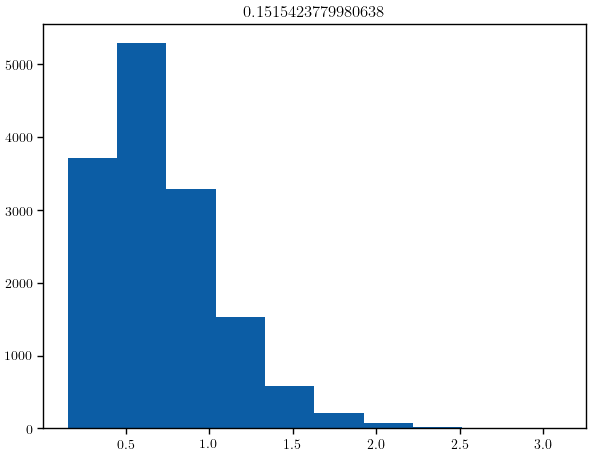

In [ ]:
plt.hist(einstein_radii)
plt.title(np.min(einstein_radii))

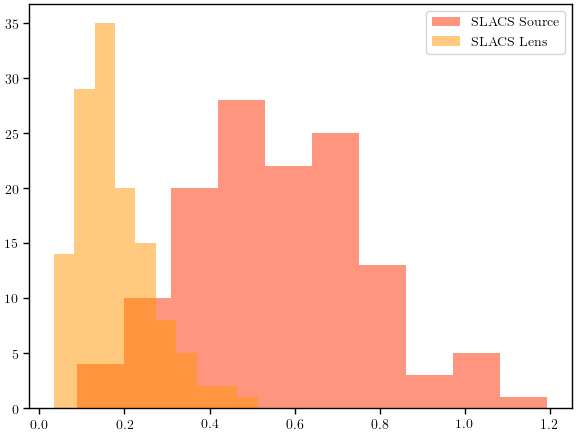

In [ ]:
_, ax = plt.subplots()
ax.hist(slacs_source_redshifts, label='SLACS Source', alpha=0.5, color=color_slacs_source)
ax.hist(slacs_lens_redshifts, label='SLACS Lens', alpha=0.5, color=color_slacs_lens)
ax.legend()
plt.show()

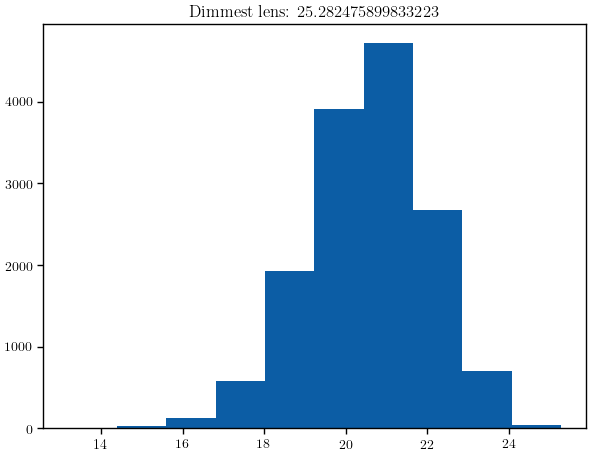

In [ ]:
plt.hist(lens_magnitudes)
plt.title(f'Dimmest lens: {np.max(lens_magnitudes)}')
plt.show()

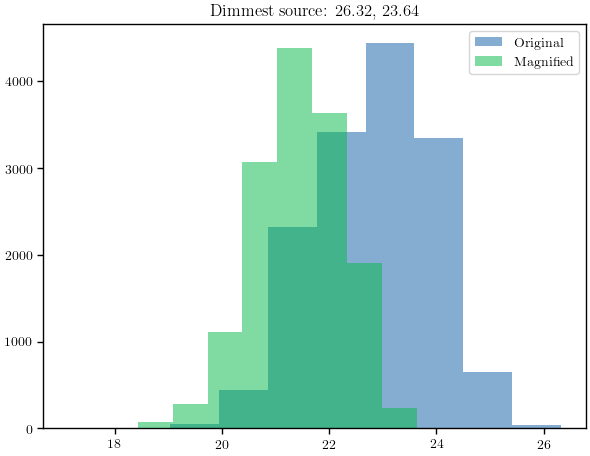

In [ ]:
magnified_source = detectable_df.loc[:, f'magtsourMagnified{source_cut_band}']

plt.hist(source_magnitudes, label='Original', alpha=0.5)
plt.hist(magnified_source, label='Magnified', alpha=0.5)
plt.title(f'Dimmest source: {np.max(source_magnitudes):.2f}, {np.max(magnified_source):.2f}')
plt.legend()
plt.show()

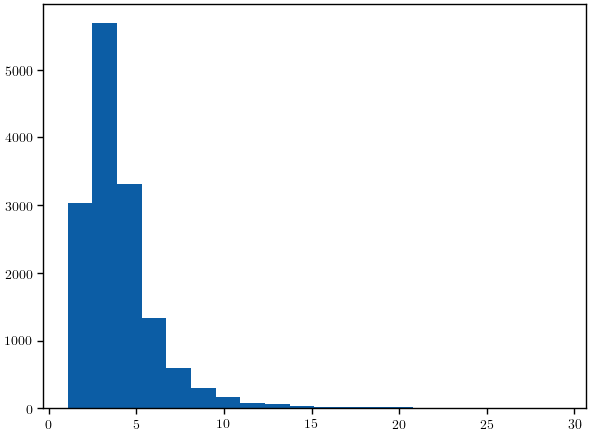

Percentage of detectable lenses with magnification > 3: 73.45%


In [ ]:
magnification = detectable_df.loc[:, 'magnsour']
plt.hist(magnification, bins=20)
plt.show()

magn_gtr_3 = detectable_df.loc[magnification > 3, :]
print(f'Percentage of detectable lenses with magnification > 3: {len(magn_gtr_3) / len(detectable_df) * 100:.2f}%')

In [ ]:
einstein_radii.sort_values(ascending=True).head(10)

9290     0.151542
732      0.151706
13098    0.151811
4704     0.152823
13538    0.153346
1726     0.154212
9935     0.154717
11235    0.154953
7806     0.154991
13333    0.155083
Name: angleins, dtype: float64

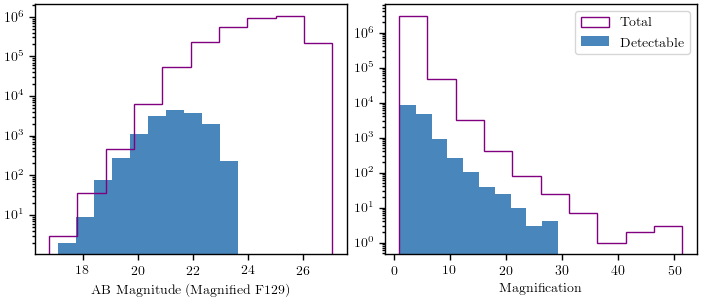

In [ ]:
total_magnified_source = total_df.loc[:, f'magtsourMagnified{source_cut_band}']  # magtsourMagnifiedF129
magnified_source = detectable_df.loc[:, f'magtsourMagnified{source_cut_band}']

total_magnification = total_df.loc[:, 'magnsour']
magnification = detectable_df.loc[:, 'magnsour']

f, ax = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
ax[0].hist(total_magnified_source, label='Total', histtype='step', color='purple')
ax[0].hist(magnified_source, label='Detectable', alpha=0.75)
ax[0].set_xlabel(f'AB Magnitude (Magnified {source_cut_band})')
ax[0].set_yscale('log')
ax[1].hist(total_magnification, label='Total', histtype='step', color='purple')
ax[1].hist(magnification, label='Detectable', alpha=0.75)
ax[1].set_xlabel('Magnification')
ax[1].set_yscale('log')
plt.legend()
plt.show()

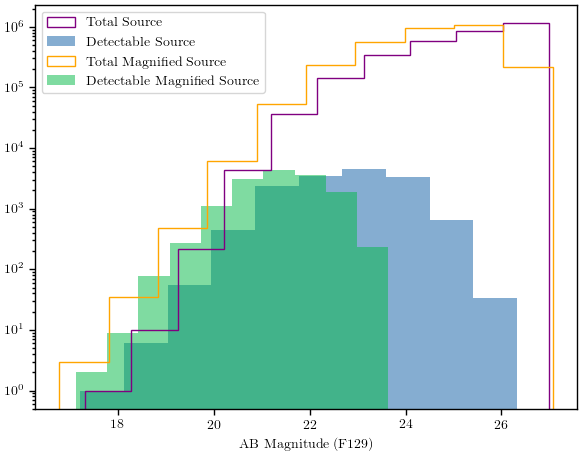

In [ ]:
plt.hist(total_source_magnitudes, label='Total Source', histtype='step', color='purple')
plt.hist(source_magnitudes, label='Detectable Source', alpha=0.5)
plt.hist(total_magnified_source, label='Total Magnified Source', histtype='step', color='orange')
plt.hist(magnified_source, label='Detectable Magnified Source', alpha=0.5)
plt.xlabel(f'AB Magnitude ({source_cut_band})')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
source_mags_f087 = detectable_df.loc[:, f'magtsourF087']
source_mags_f106 = detectable_df.loc[:, f'magtsourF106']
source_mags_f129 = detectable_df.loc[:, f'magtsourF129']
source_mags_f158 = detectable_df.loc[:, f'magtsourF158']
source_mags_f184 = detectable_df.loc[:, f'magtsourF184']

lens_mags_f087 = detectable_df.loc[:, f'magtlensF087']
lens_mags_f106 = detectable_df.loc[:, f'magtlensF106']
lens_mags_f129 = detectable_df.loc[:, f'magtlensF129']
lens_mags_f158 = detectable_df.loc[:, f'magtlensF158']
lens_mags_f184 = detectable_df.loc[:, f'magtlensF184']

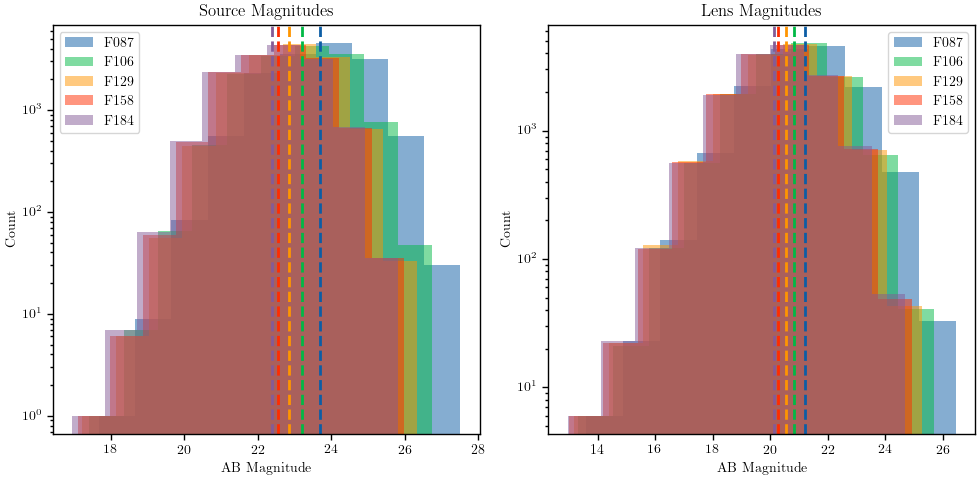

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Source Magnitudes
axs[0].hist(source_mags_f087, label='F087', alpha=0.5, color='C0')
axs[0].hist(source_mags_f106, label='F106', alpha=0.5, color='C1')
axs[0].hist(source_mags_f129, label='F129', alpha=0.5, color='C2')
axs[0].hist(source_mags_f158, label='F158', alpha=0.5, color='C3')
axs[0].hist(source_mags_f184, label='F184', alpha=0.5, color='C4')

axs[0].axvline(np.mean(source_mags_f087), color='C0', linestyle='--')
axs[0].axvline(np.mean(source_mags_f106), color='C1', linestyle='--')
axs[0].axvline(np.mean(source_mags_f129), color='C2', linestyle='--')
axs[0].axvline(np.mean(source_mags_f158), color='C3', linestyle='--')
axs[0].axvline(np.mean(source_mags_f184), color='C4', linestyle='--')

axs[0].set_xlabel('AB Magnitude')
axs[0].set_ylabel('Count')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_title('Source Magnitudes')

# Lens Magnitudes
axs[1].hist(lens_mags_f087, label='F087', alpha=0.5, color='C0')
axs[1].hist(lens_mags_f106, label='F106', alpha=0.5, color='C1')
axs[1].hist(lens_mags_f129, label='F129', alpha=0.5, color='C2')
axs[1].hist(lens_mags_f158, label='F158', alpha=0.5, color='C3')
axs[1].hist(lens_mags_f184, label='F184', alpha=0.5, color='C4')

axs[1].axvline(np.mean(lens_mags_f087), color='C0', linestyle='--')
axs[1].axvline(np.mean(lens_mags_f106), color='C1', linestyle='--')
axs[1].axvline(np.mean(lens_mags_f129), color='C2', linestyle='--')
axs[1].axvline(np.mean(lens_mags_f158), color='C3', linestyle='--')
axs[1].axvline(np.mean(lens_mags_f184), color='C4', linestyle='--')

axs[1].set_xlabel('AB Magnitude')
axs[1].set_ylabel('Count')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_title('Lens Magnitudes')

plt.tight_layout()
# plt.savefig(os.path.join(figure_dir, 'source_lens_mags.png'))
plt.show()